In [5]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 955436728715951332
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14626652160
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8280706194553705675
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [6]:
#!pip install tensorflow-privacy

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import numpy as np
import pandas as pd
import os
import csv
import pywt
from scipy import stats, special
import matplotlib.pyplot as plt

path = ''

import tensorflow as tf

from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1
from tensorflow.keras.utils import to_categorical

# privacy package
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import LSTM,Dense
from keras.optimizers import Adam

# set random seed
import random
random.seed(19122)
from keras.layers import LSTM
# set random seed
np.random.seed(19122)
tf.random.set_seed(19122)

tf.compat.v1.enable_eager_execution()
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackResultsCollection
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import PrivacyMetric
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import PrivacyReportMetadata
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import privacy_report

import warnings
warnings.filterwarnings("ignore")

In [9]:
%cd /content/drive/MyDrive/Colab Notebooks/RIS/MIT

/content/drive/MyDrive/Colab Notebooks/RIS/MIT


## Data

In [10]:
def denoise(data):
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))

    datarec = pywt.waverec(coeffs, 'sym4')

    return datarec

path = 'mitbih_database/'
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt
records = list()
annotations = list()
filenames.sort()

# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)

    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

In [11]:
def add_impulse_noise(signal, probability, amplitude):
    noisy_signal = signal.copy()
    for i in range(len(signal)):
        if np.random.rand() < probability:
            noisy_signal[i] += amplitude
    return noisy_signal

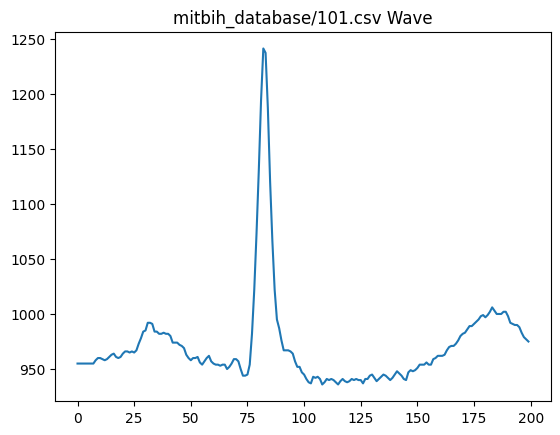

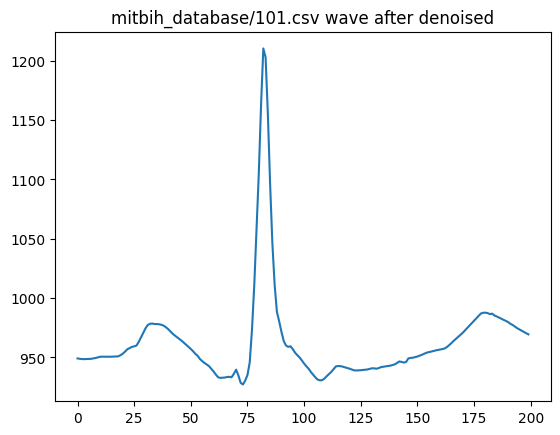

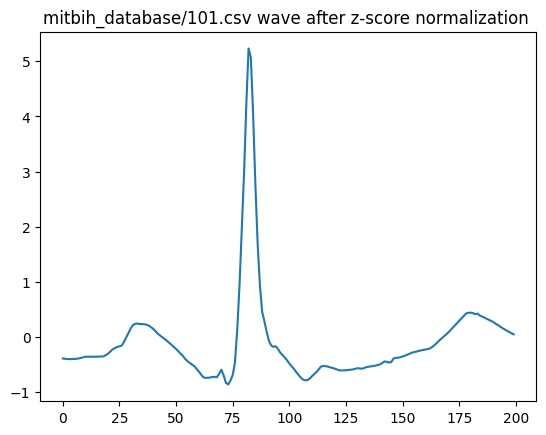

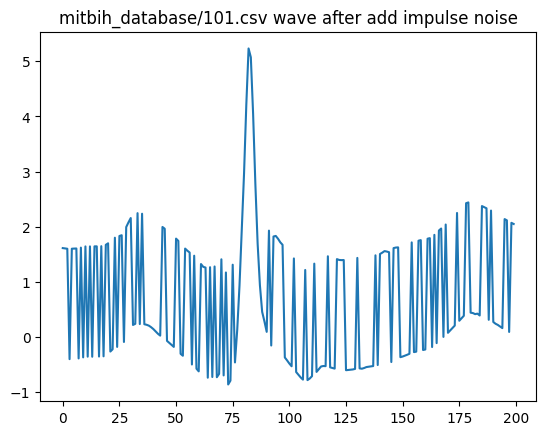

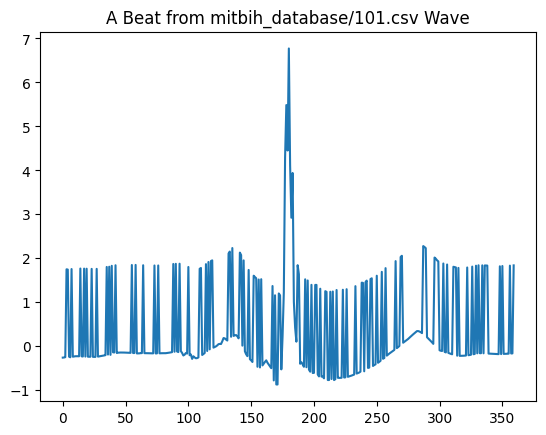

(100012, 360) (100012,)


In [12]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1

    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave")
        plt.plot(signals[0:200])
        plt.show()

    signals = denoise(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after denoised")
        plt.plot(signals[0:200])
        plt.show()

    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after z-score normalization ")
        plt.plot(signals[0:200])
        plt.show()

    #### impulse noise
    impulse_probability = 0.3  # Adjust the probability as needed
    impulse_amplitude = 2  # Adjust the amplitude as needed
    signals = add_impulse_noise(signals, impulse_probability, impulse_amplitude)
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after add impulse noise")
        plt.plot(signals[0:200])
        plt.show()

    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines()
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
#                 if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
#                     pass
#                 else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat
                    if r is 1 and not example_beat_printed:
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))


(100012, 361)
0.0    75011
1.0     8071
2.0     7255
4.0     7129
3.0     2546
Name: 360, dtype: int64


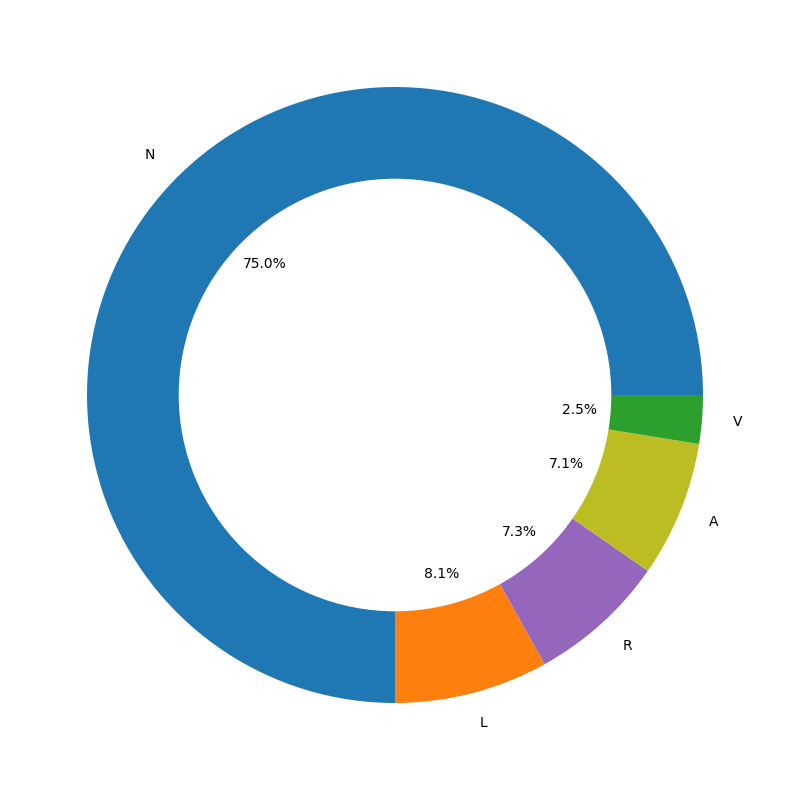

In [13]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])

print(np.shape(X))

X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [14]:
train, test = train_test_split(X_train_df, test_size=0.20)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x))

X_train :  (80009, 361)
X_test  :  (20003, 361)
(80009, 5) (20003, 5)
(80009, 360, 1) (20003, 360, 1)


## PrivacyMetric

In [15]:
class PrivacyMetrics(tf.keras.callbacks.Callback):
  def __init__(self, epochs_per_report, model_name):
    self.epochs_per_report = epochs_per_report
    self.model_name = model_name
    self.attack_results = []

  def on_epoch_end(self, epoch, logs=None):
    epoch = epoch+1

    if epoch % self.epochs_per_report != 0:
      return

    print(f'\nRunning privacy report for epoch: {epoch}\n')

    print('Predict on train...')
    logits_train = model.predict(train_x, batch_size=batch_size)
    print('Predict on test...')
    logits_test = model.predict(test_x, batch_size=batch_size)

    print('Apply softmax to get probabilities from logits...')
    prob_train = tf.nn.softmax(logits_train, axis=-1)
    prob_test = tf.nn.softmax(logits_test)

    print('Compute losses...')
    cce = tf.keras.backend.categorical_crossentropy
    constant = tf.keras.backend.constant

    y_train_onehot = to_categorical(train_y)
    y_test_onehot = to_categorical(test_y)

    prob_train_onehot = to_categorical(prob_train)
    prob_test_onehot = to_categorical(prob_test)

    loss_train = cce(constant(train_y), constant(prob_train), from_logits=False).numpy()
    loss_test = cce(constant(test_y), constant(prob_test), from_logits=False).numpy()

    print("Add metadata")
    # Add metadata to generate a privacy report.
    privacy_report_metadata = PrivacyReportMetadata(
        # Show the validation accuracy on the plot
        # It's what you send to train_accuracy that gets plotted.
        accuracy_train=logs['val_accuracy'],
        accuracy_test=logs['val_accuracy'],
        epoch_num=epoch,
        model_variant_label=self.model_name)

    print("Start AttackInputData")
    attack_input = AttackInputData(
      logits_train = logits_train,
      logits_test = logits_test,
      loss_train = loss_train,
      loss_test = loss_test,
      labels_train = np.argmax(train_y, axis=1),
      labels_test = np.argmax(test_y, axis=1)
    )
    print("Start SlicingSpec")
    slicing_spec = SlicingSpec(
        entire_dataset = True,
        by_class = True,
        by_percentiles = False,
    by_classification_correctness = True)
    print("Start attack_types")
    attack_types = [
        AttackType.THRESHOLD_ENTROPY_ATTACK,
        AttackType.MULTI_LAYERED_PERCEPTRON,
    ]
    print("Start Run Attacks")
    attacks_result = mia.run_attacks(attack_input=attack_input,
                                    slicing_spec=slicing_spec,
                                    attack_types=attack_types,
                                    privacy_report_metadata=privacy_report_metadata
                                    )


    self.attack_results.append(attacks_result)

## Model

In [16]:
model = Sequential()

model.add(LSTM(32, return_sequences=True, activation='tanh', input_shape=(360,1)))
model.add(LSTM(64, return_sequences=True, activation='tanh'))
model.add(LSTM(64, return_sequences=True, activation='tanh'))
model.add(LSTM(64, return_sequences=False, activation='tanh'))
model.add(Dense(32,activation='relu'))
model.add(Dense(5,activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'], run_eagerly=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 360, 32)           4352      
                                                                 
 lstm_1 (LSTM)               (None, 360, 64)           24832     
                                                                 
 lstm_2 (LSTM)               (None, 360, 64)           33024     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 97477 (380.77 KB)
Trainable params: 97477 

## Train

In [17]:
epochs_per_report = 1
batch_size = 512
callback = PrivacyMetrics(epochs_per_report, "sequential_2")

all_reports = []

history = model.fit(
      train_x,
      train_y,
      batch_size=batch_size,
      epochs=25,
      validation_data=(test_x, test_y),
      callbacks=[callback],
      shuffle=True)

all_reports.extend(callback.attack_results)

Epoch 1/25


157/157 [==============================] - ETA: 0s - loss: 0.9358 - accuracy: 0.7429
Running privacy report for epoch: 1

Predict on train...
157/157 [==============================] - 9s 57ms/step
Predict on test...
40/40 [==============================] - 2s 43ms/step
Apply softmax to get probabilities from logits...
Compute losses...
Add metadata
Start AttackInputData
Start SlicingSpec
Start attack_types
Start Run Attacks
157/157 [==============================] - 145s 901ms/step - loss: 0.9358 - accuracy: 0.7429 - val_loss: 0.8809 - val_accuracy: 0.7539
Epoch 2/25
157/157 [==============================] - ETA: 0s - loss: 0.8937 - accuracy: 0.7490
Running privacy report for epoch: 2

Predict on train...
157/157 [==============================] - 8s 49ms/step
Predict on test...
40/40 [==============================] - 2s 43ms/step
Apply softmax to get probabilities from logits...
Compute losses...
Add metadata
Start AttackInputData
Start SlicingSpec
Start attack_types
Start Run Atta

In [18]:
results = AttackResultsCollection(all_reports)

## Evaluate

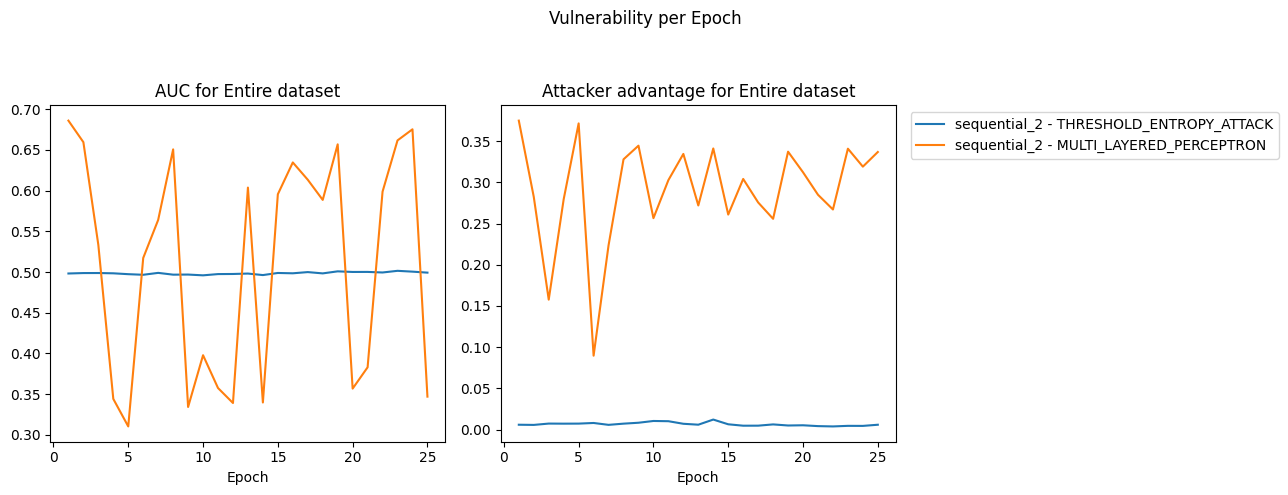

In [19]:
privacy_metrics = (PrivacyMetric.AUC, PrivacyMetric.ATTACKER_ADVANTAGE)
epoch_plot = privacy_report.plot_by_epochs(
    results, privacy_metrics=privacy_metrics)

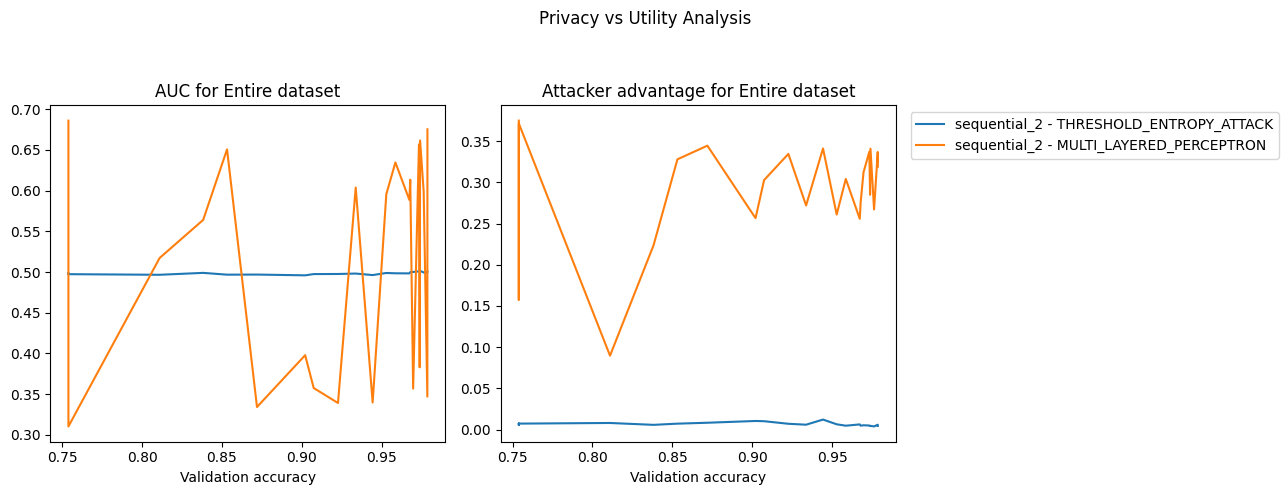

In [20]:
privacy_metrics = (PrivacyMetric.AUC, PrivacyMetric.ATTACKER_ADVANTAGE)
utility_privacy_plot = privacy_report.plot_privacy_vs_accuracy(
    results, privacy_metrics=privacy_metrics)

for axis in utility_privacy_plot.axes:
  axis.set_xlabel('Validation accuracy')

## Evaluate2

In [21]:
print(all_reports[-1].summary(by_slices=True))

Best-performing attacks over all slices
  MULTI_LAYERED_PERCEPTRON (with 59930 training and 15081 test examples) achieved an AUC of 0.68 on slice CLASS=0
  MULTI_LAYERED_PERCEPTRON (with 59930 training and 15081 test examples) achieved an advantage of 0.36 on slice CLASS=0
  THRESHOLD_ENTROPY_ATTACK (with 5796 training and 1459 test examples) achieved a positive predictive value of 1.00 on slice CLASS=2
  MULTI_LAYERED_PERCEPTRON (with 80009 training and 20003 test examples) achieved top-5 epsilon lower bounds of 1.9734, 1.7551, 1.6528, 1.4772, 1.2385 on slice Entire dataset

Best-performing attacks over slice: "Entire dataset"
  THRESHOLD_ENTROPY_ATTACK (with 80009 training and 20003 test examples) achieved an AUC of 0.50
  MULTI_LAYERED_PERCEPTRON (with 80009 training and 20003 test examples) achieved an advantage of 0.34
  MULTI_LAYERED_PERCEPTRON (with 80009 training and 20003 test examples) achieved a positive predictive value of 0.92
  MULTI_LAYERED_PERCEPTRON (with 80009 trainin

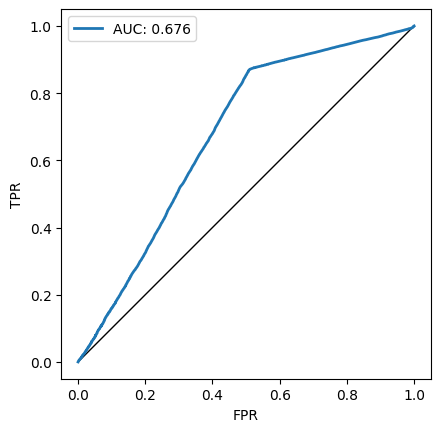

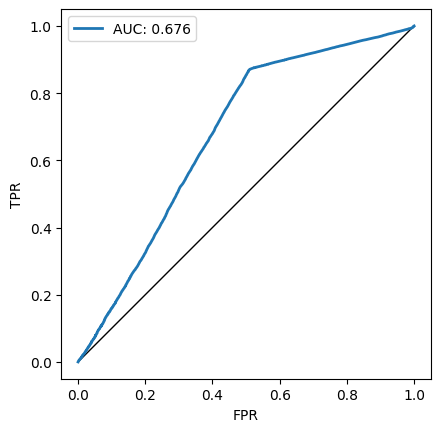

In [22]:
import tensorflow_privacy.privacy.membership_inference_attack.plotting as plotting
plotting.plot_roc_curve(all_reports[-1].get_result_with_max_auc().roc_curve)